# My Approach: Heuristic Intent Distribution Exploration
I need to get an insight into the true intents inside my Twitter data. Doing it by keyword might prove to be a good baseline way to do this. 


Using keywords as a starting point might offer a strong foundational approach for this task. I'm building upon this concept by employing heuristic clustering to organize my intents, aiming to minimize overlaps between them. The goal is to distill a set of intents that are both distinct and exclusive, enhancing Eve bot's ability to differentiate between them.

I drew inspiration from observing other solutions, particularly the "semantic fingerprint" concept implemented by cortex, although the specific workings were undisclosed. This prompted me to devise my approach. Initially, I considered branching off into manual selection of 1000 examples, but I realized this was impractical and overly laborious.

This notebook serves as a strategy for generating training data for intent classification.

In [1]:
import re 
import string 
import pandas as pd
print(f'pandas: {pd.__version__}')
import numpy as np
print(f'numpy: {np.__version__}')
# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
# Making my visualizations pretty
sns.set_style('whitegrid')
# Combination exploration
import itertools

# NLTK 
from nltk.corpus import stopwords

# Store intents 
import yaml

ModuleNotFoundError: No module named 'pandas'

In [2]:
# Loading back processed data
processed_v1 = pd.read_pickle("../data/processed/processed_v1.pkl")
processed_v2 = pd.read_pickle("../data/processed/processed_v2.pkl") 

In [71]:
processed_v2 = processed_v2.reset_index(drop=True)

## Brief Keyword Search EDA
Using this as a tool to look at Tweets.

In [77]:
tokens_pos = processed_v2["outbound_tokens_pos"][4]
stop_words = set(stopwords.words('english'))
words = [token.split(":")[0] for token in tokens_pos if token.split(":")[0] != "-PRON-" and len(token.split(":")[0]) > 1 and token.split(":")[0] not in stop_words]
words


['sorry',
 'wait',
 'receive',
 'email',
 'soon',
 'estimate',
 'delivery',
 'date',
 'fj']

In [57]:
processed_v2["processed_inbound_tokens"] = processed_v2["inbound_tokens_pos"].apply(lambda x: x.split())

,inbound_text,author_id,created_at,outbound_text,response_tweet_id,inbound_lang,inbound_hashtags,outbound_hashtags,clean_inbound_text,clean_outbound_text,outbound_tokens_pos,inbound_tokens_pos
4,@AmazonHelp 3 different people have given 3 di...,AmazonHelp,2017-10-31 23:28:00+00:00,@115820 We'd like to take a further look into ...,619,en,[],[],different people have given different answers ...,wed like to take a further look into this with...,"[-PRON-: NOUN, d: VERB, like: VERB, to: NOUN, ...","[different: NOUN, people: NOUN, have: NOUN, gi..."
5,Way to drop the ball on customer service @1158...,AmazonHelp,2017-10-31 22:29:00+00:00,@115820 I'm sorry we've let you down! Without ...,616,en,[],[],way to drop the ball on customer service so pi...,i am sorry we have let you down without provid...,"[i: NOUN, be: NOUN, sorry: NOUN, -PRON-: NOUN,...","[way: NOUN, to: NOUN, drop: VERB, the: NOUN, b..."
6,@115823 I want my amazon payments account CLOS...,AmazonHelp,2017-10-31 22:28:34+00:00,@115822 I am unable to affect your account via...,NaN,en,[],[],i want my amazon payments account closed dm me...,i am unable to affect your account via twitter...,"[i: NOUN, be: NOUN, unable: NOUN, to: NOUN, af...","[i: NOUN, want: VERB, -PRON-: NOUN, amazon: NO..."
9,@AmazonHelp @115826 Yeah this is crazy we’re l...,AmazonHelp,2017-11-01 12:53:34+00:00,@115827 Thanks for your patience. ^KM,NaN,en,[],[],yeah this is crazy were less than a week away ...,thanks for your patience km,"[thank: NOUN, for: NOUN, -PRON-: NOUN, patienc...","[yeah: NOUN, this: NOUN, be: NOUN, crazy: NOUN..."
10,@115828 How about you guys figure out my Xbox ...,AmazonHelp,2017-10-31 22:28:00+00:00,@115826 I'm sorry for the wait. You'll receive...,627,en,[],[],how about you guys figure out my xbox one x pr...,i am sorry for the wait you will receive an em...,"[i: NOUN, be: NOUN, sorry: NOUN, for: NOUN, th...","[how: NOUN, about: NOUN, -PRON-: NOUN, guy: NO..."


In [81]:
processed_v2["inbound_tokens"] = processed_v2["inbound_tokens_pos"].apply(lambda x: [token.split(":")[0] for token in x if token.split(":")[0] != "-PRON-" and len(token.split(":")[0]) > 1 and token.split(":")[0] not in stop_words])

processed_v2["outbound_tokens"] = processed_v2["outbound_tokens_pos"].apply(lambda x: [token.split(":")[0] for token in x if token.split(":")[0] != "-PRON-" and len(token.split(":")[0]) > 1 and token.split(":")[0] not in stop_words])

In [82]:
processed_v2.head()

,inbound_text,author_id,created_at,outbound_text,response_tweet_id,inbound_lang,inbound_hashtags,outbound_hashtags,clean_inbound_text,clean_outbound_text,outbound_tokens_pos,inbound_tokens_pos,inbound_tokens,outbound_tokens
0,@AmazonHelp 3 different people have given 3 di...,AmazonHelp,2017-10-31 23:28:00+00:00,@115820 We'd like to take a further look into ...,619,en,[],[],different people have given different answers ...,wed like to take a further look into this with...,"[-PRON-: NOUN, d: VERB, like: VERB, to: NOUN, ...","[different: NOUN, people: NOUN, have: NOUN, gi...","[different, people, give, different, answer, s...","[like, take, look, please, reach, phone, chat,..."
1,Way to drop the ball on customer service @1158...,AmazonHelp,2017-10-31 22:29:00+00:00,@115820 I'm sorry we've let you down! Without ...,616,en,[],[],way to drop the ball on customer service so pi...,i am sorry we have let you down without provid...,"[i: NOUN, be: NOUN, sorry: NOUN, -PRON-: NOUN,...","[way: NOUN, to: NOUN, drop: VERB, the: NOUN, b...","[way, drop, ball, customer, service, pissed, r...","[sorry, let, without, provide, personal, infor..."
2,@115823 I want my amazon payments account CLOS...,AmazonHelp,2017-10-31 22:28:34+00:00,@115822 I am unable to affect your account via...,NaN,en,[],[],i want my amazon payments account closed dm me...,i am unable to affect your account via twitter...,"[i: NOUN, be: NOUN, unable: NOUN, to: NOUN, af...","[i: NOUN, want: VERB, -PRON-: NOUN, amazon: NO...","[want, amazon, payment, account, close, dm, pl...","[unable, affect, account, via, twitter, real, ..."
3,@AmazonHelp @115826 Yeah this is crazy we’re l...,AmazonHelp,2017-11-01 12:53:34+00:00,@115827 Thanks for your patience. ^KM,NaN,en,[],[],yeah this is crazy were less than a week away ...,thanks for your patience km,"[thank: NOUN, for: NOUN, -PRON-: NOUN, patienc...","[yeah: NOUN, this: NOUN, be: NOUN, crazy: NOUN...","[yeah, crazy, less, week, away, still, ship, i...","[thank, patience, km]"
4,@115828 How about you guys figure out my Xbox ...,AmazonHelp,2017-10-31 22:28:00+00:00,@115826 I'm sorry for the wait. You'll receive...,627,en,[],[],how about you guys figure out my xbox one x pr...,i am sorry for the wait you will receive an em...,"[i: NOUN, be: NOUN, sorry: NOUN, for: NOUN, th...","[how: NOUN, about: NOUN, -PRON-: NOUN, guy: NO...","[guy, figure, xbox, one, project, scorpio, edi...","[sorry, wait, receive, email, soon, estimate, ..."


In [12]:
# Search by keywords (single keyword filter)
keyword = "quality"

# Seeing what the processed Tweets look like
filt = [(i, comment_txt) for i, comment_txt in enumerate(processed_v2["clean_inbound_text"]) if keyword in comment_txt]
filtered = processed_v2.iloc[[i[0] for i in filt]]
print(f"{len(filtered)} Tweets contain the keyword {keyword}")
filtered

372 Tweets contain the keyword quality


,inbound_text,author_id,created_at,outbound_text,response_tweet_id,inbound_lang,inbound_hashtags,outbound_hashtags,clean_inbound_text,clean_outbound_text,outbound_tokens_pos,inbound_tokens_pos
290,@AmazonHelp 24 hrs tat was given on written ma...,AmazonHelp,2017-11-01 01:30:47+00:00,"@118505 If you had replied to the email, you m...",12514,en,[],[],hrs tat was given on written mail on th oct to...,if you had replied to the email you must have ...,"[if: NOUN, -PRON-: NOUN, have: NOUN, reply: VE...","[hrs: NOUN, tat: NOUN, be: NOUN, give: VERB, o..."
512,@AmazonHelp Do u think it's just normal happen...,AmazonHelp,2017-10-18 20:10:34+00:00,"@119703 Be assured, we've shared your comments...",16871,en,[],[],do you think its just normal happeningthis is ...,be assured we have shared your comments with i...,"[be: NOUN, assure: VERB, -PRON-: NOUN, have: N...","[do: NOUN, -PRON-: NOUN, think: VERB, -PRON-: ..."
513,@AmazonHelp Do u think it's just normal happen...,AmazonHelp,2017-10-18 20:09:33+00:00,@119703 We understand your situation. Apologie...,NaN,en,[],[],do you think its just normal happeningthis is ...,we understand your situation apologies for the...,"[-PRON-: NOUN, understand: VERB, -PRON-: NOUN,...","[do: NOUN, -PRON-: NOUN, think: VERB, -PRON-: ..."
1304,@AmazonHelp I purchased redmi4 few function of...,AmazonHelp,2017-10-20 09:31:32+00:00,"@122101 here: https://t.co/2t6DQoUmNZ, we'll h...",27875,en,[],[],i purchased redmi few function of phone not wo...,here well help look into it ap,"[here: NOUN, well: NOUN, help: NOUN, look: VER...","[i: NOUN, purchase: VERB, redmi: VERB, few: NO..."
1305,@AmazonHelp I purchased redmi4 few function of...,AmazonHelp,2017-10-20 09:31:32+00:00,@122101 I'm sorry the product isn't working as...,NaN,en,[],[],i purchased redmi few function of phone not wo...,i am sorry the product is not working as expec...,"[i: NOUN, be: NOUN, sorry: NOUN, the: NOUN, pr...","[i: NOUN, purchase: VERB, redmi: VERB, few: NO..."
...,...,...,...,...,...,...,...,...,...,...,...,...
120067,very disappointed with @115830 !! Ordered a Ch...,AmazonHelp,2017-11-29 09:53:28+00:00,@811375 Hi Jess! Was the item sold directly by...,2934401,en,[],[],very disappointed with ordered a christmas pre...,hi jess was the item sold directly by amazon o...,"[hi: NOUN, jess: NOUN, be: NOUN, the: NOUN, it...","[very: NOUN, disappointed: NOUN, with: NOUN, o..."
120677,@AmazonHelp I wonder if you'll do. We'll see w...,AmazonHelp,2017-11-29 16:00:01+00:00,@813367 I get your concern. Once you share the...,2945617,en,[],[],i wonder if you will do well see where this go...,i get your concern once you share the details ...,"[i: NOUN, get: VERB, -PRON-: NOUN, concern: NO...","[i: NOUN, wonder: VERB, if: NOUN, -PRON-: NOUN..."
120888,Something has gone downhill with @117093 quali...,AmazonHelp,2017-11-29 17:30:35+00:00,@814859 I'm sorry for the poor experiences! Th...,NaN,en,[],[],something has gone downhill with quality contr...,i am sorry for the poor experiences this is no...,"[i: NOUN, be: NOUN, sorry: NOUN, for: NOUN, th...","[something: NOUN, have: NOUN, go: VERB, downhi..."
121318,@115821 For a company claiming to be “Earth's ...,AmazonHelp,2017-11-29 21:12:01+00:00,@817317 I'm sorry for the poor experience. Ple...,NaN,en,[],[],for a company claiming to be earths most custo...,i am sorry for the poor experience please send...,"[i: NOUN, be: NOUN, sorry: NOUN, for: NOUN, th...","[for: NOUN, a: NOUN, company: NOUN, claim: VER..."


In [83]:
# Load the YAML file
with open("../objects/intents_amazon_support.yml", 'r') as stream:
    try:
        intent_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [84]:
for key, values in intent_dict.items():
    for intent in values:
        # Seeing what the processed Tweets look like
        filt = [(i, comment_txt) for i, comment_txt in enumerate(processed_v2["clean_inbound_text"]) if intent in comment_txt]
        filtered = processed_v2.iloc[[i[0] for i in filt]]
        print(f"{len(filtered)} Tweets contain the intent {intent}")

1751 Tweets contain the intent tracking
24283 Tweets contain the intent order
628 Tweets contain the intent shipment
3643 Tweets contain the intent late
1159 Tweets contain the intent status
1215 Tweets contain the intent carrier
2886 Tweets contain the intent update
2582 Tweets contain the intent number
1962 Tweets contain the intent info
4808 Tweets contain the intent received
2452 Tweets contain the intent details
9287 Tweets contain the intent service
372 Tweets contain the intent quality
6185 Tweets contain the intent product
874 Tweets contain the intent damaged
4808 Tweets contain the intent received
5225 Tweets contain the intent refund
4079 Tweets contain the intent return
4279 Tweets contain the intent issue
24283 Tweets contain the intent order
880 Tweets contain the intent packaging
557 Tweets contain the intent proper
1295 Tweets contain the intent working
1088 Tweets contain the intent expected
1058 Tweets contain the intent different
10269 Tweets contain the intent prime

In [85]:
processed_v2["clean_inbound_text"][1000]

'i had ordered a redmi gb gb delivered faulty piece want reorder the product price was going out nxt day'

In [86]:
# Sentence count in each tweet of "clean_inbound_text"
processed_v2["sentence_count"] = processed_v2['clean_inbound_text'].apply(lambda x: len(str(x).split("\n")))

In [87]:
# Drop this for now 
processed_v2["sentence_count"]
processed_v2.drop("sentence_count", axis=1, inplace=True)

In [89]:
 # code script for donwloading table data from wikipedia page
def calculate_indirect_features(df, eng_stopwords=None):
    """
    Calculate indirect features for a DataFrame based on the 'comment_text' column.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data.
    eng_stopwords (set): Set of English stopwords.

    Returns:
    df (pandas.DataFrame): DataFrame with the new features added.
    """

    # Sentence count in each comment
    # df["count_sent"] = df["comment_text"].apply(lambda x: len(re.findall("\n", str(x))) + 1)

    # Word count in each comment
    df["count_word"] = df["clean_inbound_text"].apply(lambda x: len(str(x).split()))

    # Unique word count
    df["count_unique_word"] = df["clean_inbound_text"].apply(lambda x: len(set(str(x).split())))

    # Letter count
    df["count_letters"] = df["clean_inbound_text"].apply(lambda x: len(str(x)))

    # Punctuation count
    df["count_punctuations"] = df["clean_inbound_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

    # Upper case words count
    # I am removing this, doesn't serve much purpose. Checks if a word has all characters in uppercase
    # df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

    # Title case words count
    # I am removing this, doesn't serve much purpose. Checks if each word in the sentence starts with an uppercase letter 
    # df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))


    # Number of stopwords
    # TODO: Check if the calculation of this feature is necessary or redundant 
    # df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

    # Average length of the words
    df["mean_word_len"] = df["clean_inbound_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

    return df

In [90]:
processed_v2 = calculate_indirect_features(processed_v2)

c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [91]:
# Drop all columns with same values or unnecessary columns 
processed_v2["inbound_hashtags"].value_counts()

inbound_hashtags
[]                                                                                                         111940
[#Amazon]                                                                                                     352
[#AmazonIndia]                                                                                                263
[#amazon]                                                                                                     180
[#AmazonPrime]                                                                                                123
                                                                                                            ...  
[#AForcaDoQuererFinal]                                                                                          1
[#El155ARV, #AForçaDoQuererFinal]                                                                               1
[#TwitterIn4Words]                                                     

In [92]:
processed_v2["outbound_hashtags"].value_counts()

outbound_hashtags
[]                              122246
[#TNFonPrimeVideo]                  10
[#HappyShopping]                     5
[#happydiwali]                       5
[#s]                                 4
                                 ...  
[#1]                                 1
[#SabarKaPhalMeethaHotaHai]          1
[#shelveawarenesssaveslives]         1
[#HappyStreaming]                    1
[#adorable]                          1
Name: count, Length: 65, dtype: int64

In [93]:
processed_v2["inbound_lang"].value_counts()

inbound_lang
en    122340
Name: count, dtype: int64

In [94]:
processed_v2["count_punctuations"].value_counts()

count_punctuations
0    122340
Name: count, dtype: int64

In [95]:
processed_v2["outbound_tokens_pos"][5]

['i: NOUN',
 'be: NOUN',
 'sorry: NOUN',
 'for: NOUN',
 'the: NOUN',
 'wait: NOUN',
 'please: NOUN',
 'reach: VERB',
 'out: NOUN',
 'to: NOUN',
 '-PRON-: NOUN',
 'so: NOUN',
 '-PRON-: NOUN',
 'can: VERB',
 'take: VERB',
 'a: NOUN',
 'close: NOUN',
 'look: NOUN',
 'at: NOUN',
 'this: NOUN',
 'delivery: NOUN',
 'sh: NOUN']

**Preprocess** 
- Drop "inbound_hastags", "outbound_hashtags", "inbound_lang", "inbound_token_pos", "outbound_token_pos" and "count_punctuations" for the time being 

- I haven't used a good preprocessing scheme for extracting POS tags. I need to better it 

In [96]:
processed_v2.drop(["inbound_hashtags", "outbound_hashtags", "inbound_lang", "count_punctuations", "inbound_tokens_pos", "outbound_tokens_pos"], axis=1, inplace=True)

In [97]:
# Post-Hoc Intents: I find the keywords that is associated with a particular intent and search based on these keywords 

# Version 1: Initial Iteration: Make a dictionary to store intents and the predefined responses 

# intents = ["Greeting": ["Hi there!", "Hello"], 
#            "Closing": "Thanks for talking", 
#            "Promotion": "", 
#            "Complaint": "",
#             "Scenarios": {"Last Payment": "", "Account Details": "", 
#                           "Account Confirmation: ""}, 
#             "Location": ""}
#           ]

# Version-2: For showing progress 
# intents = {'greeting': ['hi', 'hello', 'hey','yo'], 'app': ['app', 'application'],
#           'iphone': ['iphone', 'i phone'], 'icloud': ['icloud', 'i cloud'],
#           'ios': ['io'], 'battery': ['battery'], 'watch': ['watch'], 'mac': 
#            ['mac', 'macbook', 'laptop', 'computer'], 'update': ['update'],
#           'troubleshooting': ['problem', 'trouble', 'error'],
#           'settings': ['settings', 'setting'], 'music': ['music', 'song', 'playlist'],
#           'payment': ['credit','card','payment','pay'], 'bug':['bug'], 'watch': ['tv', 'show'],
#           'network': ['internet','connection','network']}
          
# Version-3: Probable version_1 
intents = {
  "track": ["tracking", "order", "shipment", "late", "status", "carrier", "update", "number", "info", "received", "details"],
  "support": ["service"],
  "quality": ["quality", "product", "damaged", "received", "refund", "return", "issue", "order", "packaging", "proper", "working", "expected", "different"],
  "discount": ["prime", "product", "offer", "price", "sale"],
  "account": ["email", "orders", "details", "bank", "access"]
}

# Intents that require all words within it to be contained in the list (alternative filtering method)

In [98]:
# Getting a list of all my keywords so far
all_keywords = list(itertools.chain(*intents.values()))
len(all_keywords)

35

## Useful functions for Intent Classification

In [99]:
def get_key_tweets(series, keywords): 
    '''
    Takes as input the list of keywords and outputs the tweets that contains at least
    one of these keywords
    '''
    # Initialize an empty list to store the tweets that contain keywords
    keyword_tweets = []
    for tweet in series:
        for word in keywords:
            # If the keyword is found in the tweet, add the tweet to the list
            if word in tweet:
                keyword_tweets.append(tweet)
    return keyword_tweets

def get_key_tweets_all(series, keywords):
    '''
    Takes as input the list of keywords and outputs the Tweets that contains all
    of these keywords
    '''
    # Initialize an empty list to store the tweets that contain keywords
    keyword_tweets = []
    for tweet in series:
        # Check if all keywords are in the tweet
        if all(word in tweet for word in keywords):
            # Add the tweet to the list 
            keyword_tweets.append(tweet)
    return keyword_tweets

def key_absent_tweets(series, keywords): 
    '''
    Takes as input the list of keywords and outputs the tweets which don't contain any of these keywords
    '''
    # Initialize an empty list to store the tweets that do not contain any of the keywords
    keyword_absent_tweets = []
    
    # Loop over each tweet in the series
    for tweet in series:
        # Check if any keyword is not in the tweet 
        if not any(keyword in tweet for keyword in keywords): 
            # If the tweet does not contain any of the keywords, add it to the list 
            keyword_absent_tweets.append(tweet)
            
    return keyword_absent_tweets

# Getting a list of all my keywords so far 
all_keywords = list(itertools.chain(*intents.values()))
        
# Understand the code later 
def only_key_tweets(series, keywords): 
    '''Uses the all_keywords'''
    kept = []
    
    for tweet in series: 
        # Check 
        if all(elem in tweet for elem in keywords):
            kept.append(tweet)
            
    return pd.Series(kept)

# TODO: Understand this function later 
def to_set(l):
    ''' In order to make the Tweets a set to check for intersections, we need
    to make them immutable by making it a tuple because sets only accept immutable
    '''
    return set([tuple(row) for row in l])

## Intent Visualizations

In [104]:
processed_v2.head()

,inbound_text,author_id,created_at,outbound_text,response_tweet_id,clean_inbound_text,clean_outbound_text,inbound_tokens,outbound_tokens,count_word,count_unique_word,count_letters,mean_word_len
0,@AmazonHelp 3 different people have given 3 di...,AmazonHelp,2017-10-31 23:28:00+00:00,@115820 We'd like to take a further look into ...,619,different people have given different answers ...,wed like to take a further look into this with...,"[different, people, give, different, answer, s...","[like, take, look, please, reach, phone, chat,...",24,19,129,4.416667
1,Way to drop the ball on customer service @1158...,AmazonHelp,2017-10-31 22:29:00+00:00,@115820 I'm sorry we've let you down! Without ...,616,way to drop the ball on customer service so pi...,i am sorry we have let you down without provid...,"[way, drop, ball, customer, service, pissed, r...","[sorry, let, without, provide, personal, infor...",12,12,60,4.083333
2,@115823 I want my amazon payments account CLOS...,AmazonHelp,2017-10-31 22:28:34+00:00,@115822 I am unable to affect your account via...,NaN,i want my amazon payments account closed dm me...,i am unable to affect your account via twitter...,"[want, amazon, payment, account, close, dm, pl...","[unable, affect, account, via, twitter, real, ...",10,10,53,4.400000
3,@AmazonHelp @115826 Yeah this is crazy we’re l...,AmazonHelp,2017-11-01 12:53:34+00:00,@115827 Thanks for your patience. ^KM,NaN,yeah this is crazy were less than a week away ...,thanks for your patience km,"[yeah, crazy, less, week, away, still, ship, i...","[thank, patience, km]",23,23,126,4.521739
4,@115828 How about you guys figure out my Xbox ...,AmazonHelp,2017-10-31 22:28:00+00:00,@115826 I'm sorry for the wait. You'll receive...,627,how about you guys figure out my xbox one x pr...,i am sorry for the wait you will receive an em...,"[guy, figure, xbox, one, project, scorpio, edi...","[sorry, wait, receive, email, soon, estimate, ...",26,26,136,4.269231


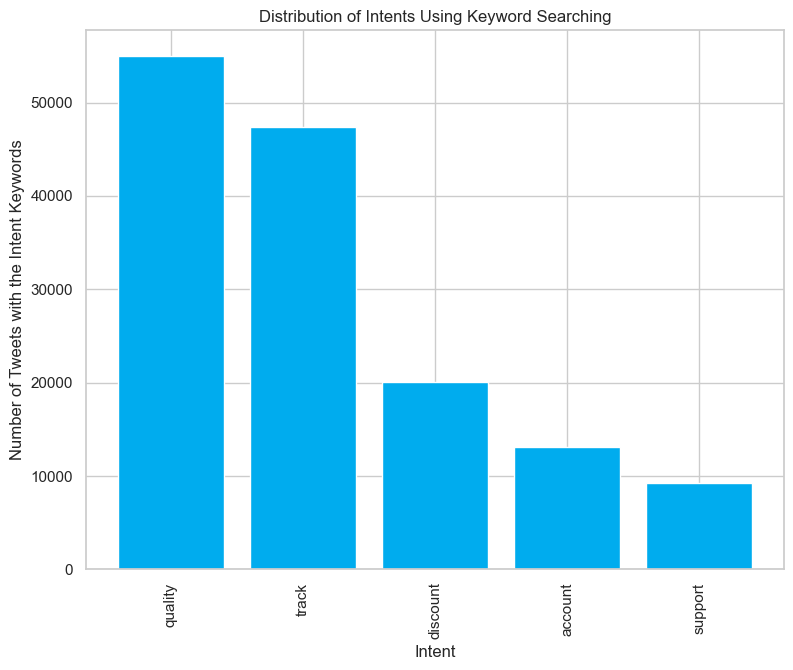

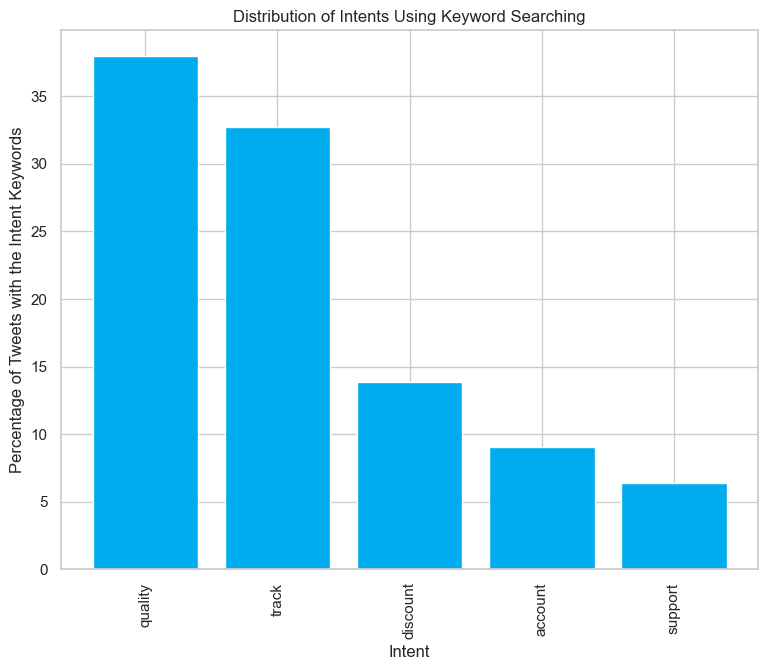

In [100]:
# Using the function above to visualize the distribution of intents in my dataset

intent_lengths = [len(get_key_tweets(processed_v2["clean_inbound_text"], intents[intent])) for intent in intents.keys()]
keywords_df = pd.DataFrame({"intents": list(intents.keys()), "intent_lengths": intent_lengths}).sort_values("intent_lengths", ascending = False)

# Visualization
plt.figure(figsize=(9,7))
plt.bar(keywords_df["intents"], keywords_df["intent_lengths"], color = "#00acee")
plt.title("Distribution of Intents Using Keyword Searching")
plt.xlabel("Intent")
plt.xticks(rotation=90)
plt.ylabel("Number of Tweets with the Intent Keywords")
plt.show()

# TODO: Add the percentage symbols and precise markers in the plot later 
# Proportions visualization
plt.figure(figsize=(9,7))
plt.bar(keywords_df["intents"], keywords_df["intent_lengths"] * 100 / 144759, color = "#00acee")
plt.title("Distribution of Intents Using Keyword Searching")
plt.xlabel("Intent")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Tweets with the Intent Keywords")
# Saving
plt.savefig("../reports/figures/intent_distribution_keyword.png")
plt.show()                                                                

In [37]:
# Seeing precise numeric counts 
keywords_df

,intents,intent_lengths
2,quality,54983
0,track,47369
3,discount,20027
4,account,13093
1,support,9287


## Captured Intents 
(This is just another version...of intents...)

In [101]:
from itertools import combinations

In [102]:
intent_pairs = combinations(intents.keys(), 2)

In [172]:
# Initializing all the thresholds for min amount of combination appearances
thres = [1000, 50, 20, 10]

In [173]:
# Intent Tweets have all the keys, and as the value contains all the tweets that contain that key, as a set
intent_tweets = {}
for key in intents.keys():
    intent_tweets[key] = to_set(get_key_tweets(processed_v2["inbound_tokens"], intents[key]))

In [123]:
intent_tweets

{'track': {('arrange',
   'call',
   'back',
   'soon',
   'possible',
   'need',
   'locate',
   'order',
   'try',
   'since',
   'day'),
  ('place',
   'order',
   'amp',
   'shortly',
   'afterward',
   'email',
   'account',
   'bombard',
   'msgs',
   'state',
   'sign',
   'multiple',
   'website'),
  ('update',
   'either',
   'discover',
   'delay',
   'notice',
   'package',
   'arrive',
   'check',
   'app'),
  ('status', 'one', 'plus', 'winner', 'list', 'th', 'june', 'contest'),
  ('shipment', 'stop', 'say', 'delay', 'cool'),
  ('number', 'call', 'case'),
  ('third',
   'party',
   'matter',
   'right',
   'since',
   'amazon',
   'get',
   'share',
   'business',
   'order',
   'place',
   'unfair'),
  ('try',
   'get',
   'ahold',
   'product',
   'two',
   'month',
   'order',
   'indefinitely',
   'delay',
   'concern',
   'may',
   'happen',
   'limit',
   'edition',
   'print',
   'anything',
   'help',
   'make',
   'sure',
   'get',
   'buy'),
  ('fc',
   'lose',
  

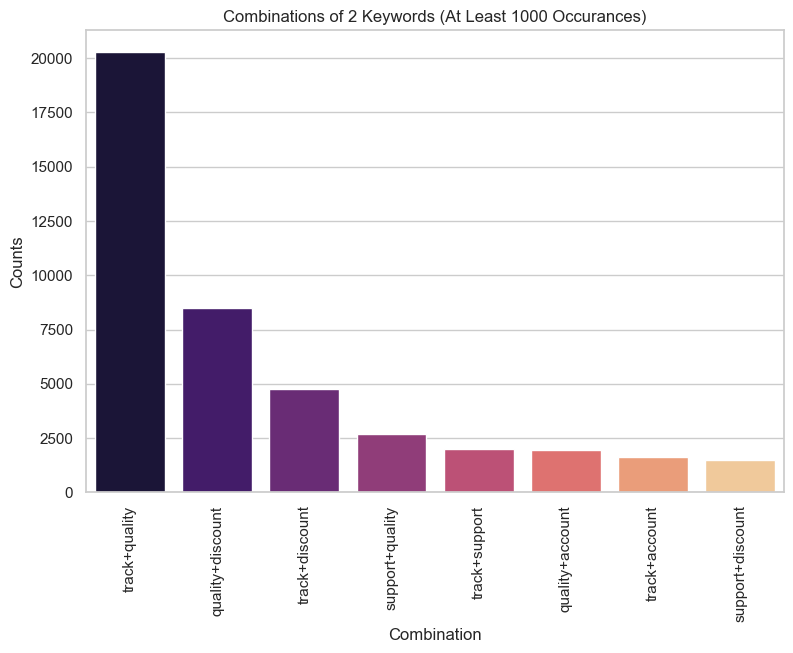

In [174]:
# Iterating through all pairs, and getting how many Tweets intersect between the pair
keyword_overlaps = {}
combs = {}

# Combinations of 2 
intent_pairs = combinations(intents.keys(), 2)

# For each pair of intent keys, find the intersection of the tweet sets 
for pair in intent_pairs:
    
    # Get the tweet sets for the 2 intents 
    tweets_1 = intent_tweets[pair[0]] # Here is a tweet 
    tweets_2 = intent_tweets[pair[1]] # Here is a tweet 
  
    # Get the intersection of the tweet sets 
    intersection = tweets_1.intersection(tweets_2)
    # If the intersection is greater than the threshold, add it to the dictionary
    if len(intersection) > thres[0]:
        keyword_overlaps[pair] = intersection
        combs[f"{pair[0]}+{pair[1]}"] = len(intersection)
        
# Visualizing as well
vis = pd.DataFrame({'Combination': list(combs.keys()), "Counts": list(combs.values())}).sort_values('Counts', ascending = False)
plt.figure(figsize=(9,6))
sns.barplot(x = vis["Combination"], y = vis["Counts"], palette = 'magma')
plt.title(f'Combinations of 2 Keywords (At Least {thres[0]} Occurances)')
plt.xticks(rotation=90)
plt.show()


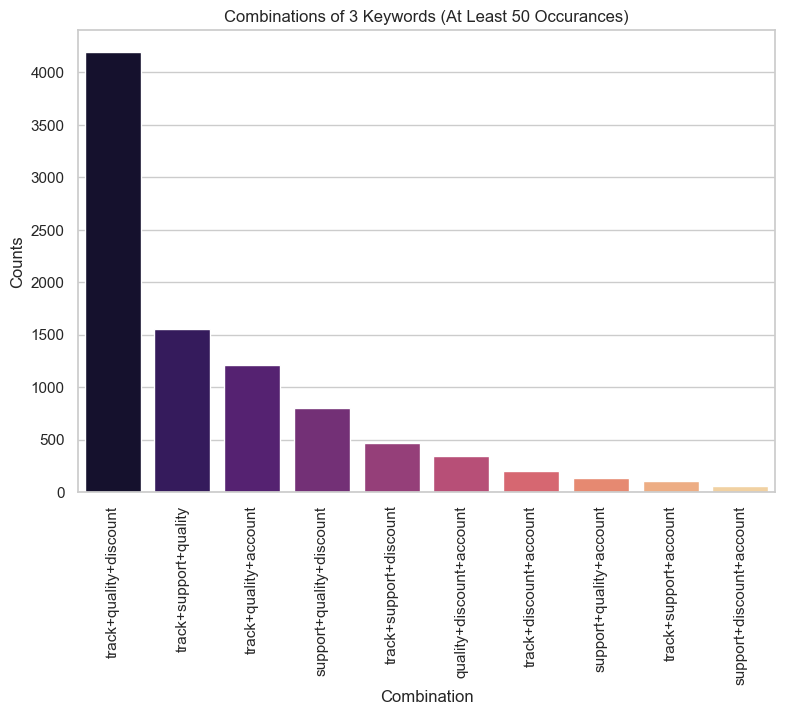

In [175]:
# Iterating through all pairs, and getting how many Tweets intersect between the pair
keyword_overlaps = {}
combs = {}

# Combinations of 2 
intent_triples = combinations(intents.keys(), 3)

# For each pair of intent keys, find the intersection of the tweet sets 
for intent_triple in intent_triples:
    
    # Get the tweet sets for the 3 intent 
    tweets_1 = intent_tweets[intent_triple[0]]
    tweets_2 = intent_tweets[intent_triple[1]]
    tweets_3 = intent_tweets[intent_triple[2]]
 
    # Get the intersection of the tweet sets 
    intersection = tweets_1.intersection(tweets_2).intersection(tweets_3)
    # If the intersection is greater than the threshold, add it to the dictionary
    if len(intersection) > thres[1]:
        keyword_overlaps[intent_triple] = intersection
        combs[f"{intent_triple[0]}+{intent_triple[1]}+{intent_triple[2]}"] = len(intersection)
        
# Visualizing as well
vis = pd.DataFrame({'Combination': list(combs.keys()), "Counts": list(combs.values())}).sort_values('Counts', ascending = False)
plt.figure(figsize=(9,6))
sns.barplot(x = vis["Combination"], y = vis["Counts"], palette = 'magma')
plt.title(f'Combinations of 3 Keywords (At Least {thres[1]} Occurances)')
plt.xticks(rotation=90)
plt.show()

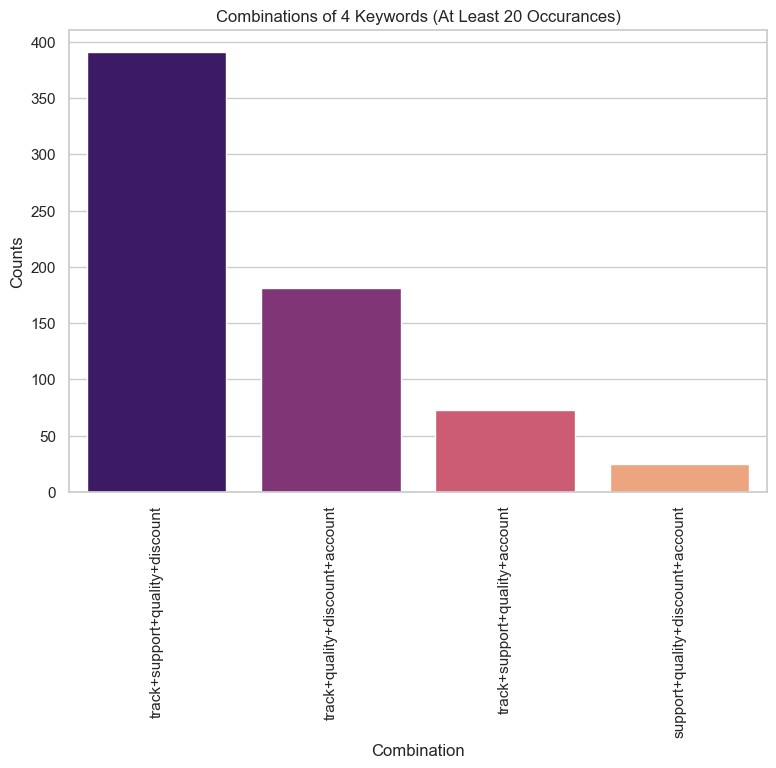

In [178]:
# Iterating through all pairs, and getting how many Tweets intersect between the pair
keyword_overlaps = {}
combs = {}

# Combinations of 2 
intent_quads = combinations(intents.keys(), 4)

# For each pair of intent keys, find the intersection of the tweet sets 
for intent_quad in intent_quads:
    
    # Get the tweet sets for the 3 intent 
    tweets_1 = intent_tweets[intent_quad[0]]
    tweets_2 = intent_tweets[intent_quad[1]]
    tweets_3 = intent_tweets[intent_quad[2]]
    tweets_4 = intent_tweets[intent_quad[3]]
 
    # Get the intersection of the tweet sets 
    intersection = tweets_1.intersection(tweets_2).intersection(tweets_3).intersection(tweets_4)
    # If the intersection is greater than the threshold, add it to the dictionary
    if len(intersection) > thres[2]:
        keyword_overlaps[intent_quad] = intersection
        combs[f"{intent_quad[0]}+{intent_quad[1]}+{intent_quad[2]}+{intent_quad[3]}"] = len(intersection)
        
# Visualizing as well
vis = pd.DataFrame({'Combination': list(combs.keys()), "Counts": list(combs.values())}).sort_values('Counts', ascending = False)
plt.figure(figsize=(9,6))
sns.barplot(x = vis["Combination"], y = vis["Counts"], palette = 'magma')
plt.title(f'Combinations of 4 Keywords (At Least {thres[2]} Occurances)')
plt.xticks(rotation=90)
plt.show()

**Observation** 
- Thus, it is probable that we find several tweets with multiple intents 
- It seems that **order tracking** and **product quality issues** are the two most major areas which customers are concerned about, rather than **massive product discounts**. Hence, it is probable that searching for cheaper options isn't on the priority list of customers. Rather their preferences are inclined towards good quality and maintainable products, though they might seem costlier. 
- Here we can observe that all combinations of both intents have atleast 1000 tweets (crossing my desired threshold of 1000)
- We might find more combinations of tweets (>=1000) with more than 3 intents, but that would require more data to process (not a priority as of now)

## Find key absent tweets 

In [ ]:
## Here, I would try to find tweets which don't contain any of the keywords
## Do it in second stage 
